<a href="https://colab.research.google.com/github/paudelsushil/adleosus/blob/main/assignment3_sus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Semantic Segmentation

## Instructions

<font color='red'>**Important Note: If you are using ChatGPT to correct your writings or errors in code, you are required to provide a citation link**</font>.

Work through the assignment 2 notebook, and use this notebook to provide your answers. Be aware that the code cell for `customDataset` in this template is with complete instruction.

To submit the assignment, you will need to use GitHub and the existing private repository you already created called `adleoxyz` (xyz is your initials)

Once you have completed the assignment:
- Commit your notebook from colab to your private GitHub repo
- The notebook should be named assignment3_xyz.ipynb, with xyz again replaced by your initials.
- There are 50 points in this assignment, with an additional 8 extra credit.

## Answers to the theoretical questions
Please provide your answers to questions 1-4 here.

(20 points total)





### **Q1.**

You are assigned the task to produce land cover maps over a diverse area. You are specifically given a Landsat-8 imagery of 15000x8000 pixels resampled to 15 meters. You are using bands 1-7, plus a DEM and derived slope raster layers as extra bands. For good measures you also produce and add 6 more spectral indices as extra layers which gives you in total 15 input bands.
land cover categories are as follows:

`{0:"unknown", 1:"forest", "2:"grassland", 3:"cultivated land", 4:"build-up areas", 5:"Water", 6:"baresoil"}`

You are provided with 10000 annotated examples for each land cover category for the purpose of training. And your employer wants to first test an MLP with a single hidden layer will be used as the model.

a) How would you proceed with this prediction task?
- What is your input to the model? What is the shape of the input in tensor form?
- What do you think is a good choice for the number of units in our single hidden layer? What is the shape of the weight and bias matrices? (5 points)

b) Seeing how talented you are, your employer asks for a fancy CNN model to be used. Given the data you have available, how can we achieve a dense prediction with a conventional CNN you played with in the second assignment? If it’s doable, how would you shape your input? (4 points)




**Answer to Q1**

a) **Predition with MLP**

    1. Input to the Model:

The input to the MLP model would consist of the 15 input bands derived from Landsat-8 imagery, DEM, slope raster layers, and spectral indices. Each pixel in the image would be represented by a vector of 15 values corresponding to the different bands and layers.

The shape of the input in tensor form would be (batch_size, height, width, channels), where:

**batch_size**: 10000

**height**: 8000

**width**: 15000

**channels**: 15

    2. Number of Units in Hidden Layer:

A good choice for the number of units in the single hidden layer of the MLP can be determined based on the complexity of the task and the capacity of the model. Since the task involves land cover classification with 7 categories, a moderate number of units, such as 128 or 256, in the hidden layer can be a reasonable starting point. Sam et al.,(2023)

    3. Shape of Weight and Bias Matrices:

For a single hidden layer MLP, the weight matrix connecting the input layer to the hidden layer would have a shape of (input_size, hidden_units), where
input_size is the number of input features (15 in this case) and
hidden_units is the number of units in the hidden layer.

The bias matrix for the hidden layer would have a shape of (hidden_units,) to account for the bias term for each hidden unit.

b)


### **Q2.**

Why is it advantageous to employ convolutional layers in a CNN architecture? Please provide short answers. (4 points)

**Hint:** There are 3 advantages


**Answer to Q2**

1. The employment of convolutional layers enables the model to preserve the spatial dimension of class probabilities.

2. Convolutional layers dramatically reduces the number of learnable parameters, and

3. Models with convolutional layers becomes invariant to the spatial dimension of input imagery used during training at inference time.

### **Q3.**

What's the main lesson learned from the design of decoder head in FCN-32, FCN-16 and FCN-8 architectures? (4 points)

**Hint:** The most precise results are obtained using FCN-8.

**Answer to Q3**

 The main lesson learned is that the most precise results are obtained using FCN-8, which uses transposed convolution for incremental upscalling and multiple skip connections that leverage the high spatial precision of earlier layers in the encoder by incorporating them in the decoder path
 dramatically improves boundary refinement.


### **Q4.**

How you can convert a VGG-16 to an FCN-32 architecture? (3 points)

**Answer to Q4**




## Coding asignments starts from here





In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%%capture
!pip install rasterio

In [ ]:
import numpy as np
import os
import pandas as pd
import numpy.ma as ma
import rasterio
import cv2
import random
import math
import numbers
from pathlib import Path
from scipy.ndimage import rotate
from scipy.ndimage import shift

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from IPython.core.debugger import set_trace

## Coding Assignment 1: Build your own U-Net


Develop a Unet model using the schematic provided in Figure 6 in the Chapter on Semantic Segmentation.

In all code cells below change "your_model_name" with the name you choose for your model. My recommendation: "unet" + "_" + "your initial".



Develope your model in a way that you can initialize it as follows:

```
model_name(n_classes, in_channels, filter_config, dropout_rate=0):
```

n_classes = number of categories in the semantic segmentation task.

in_channels = number of bands in your input image chips.

filter config = A list with integer elements that shows the number of output feature maps in each conv layer.

dropout_rate = probability to apply drop out.

You have two choices to place the dropout layer. At the end of each "conv block" or after each "pooling" layer.

**Hint:** Check SegNet code on how to structure your encoder and decoder.

(10 points)


In [ ]:
import torch
import torch.nn as nn

class unet_sus(nn.Module):
    def __init__(self, n_classes, in_channels, filter_config=(64, 128, 256, 512, 1024), dropout_rate=0):
        super(unet_sus, self).__init__()
        self.n_classes = n_classes
        self.in_channels = in_channels

        # Remove redundant redefinitions
        # filter_config = (64, 128, 256, 512, 1024)
        # dropout_rate = 0

        # Downsample
        # 1st Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, filter_config[0], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_config[0]),
            nn.ReLU(inplace=True)
        )

        # 2nd Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(filter_config[0], filter_config[1], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_config[1]),
            nn.ReLU(inplace=True)
        )

        # 3rd Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(filter_config[1], filter_config[2], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_config[2]),
            nn.ReLU(inplace=True)
        )

        # 4th Block
        self.conv4 = nn.Sequential(
            nn.Conv2d(filter_config[2], filter_config[3], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_config[3]),
            nn.ReLU(inplace=True)
        )

        # 5th Block
        self.conv5 = nn.Sequential(
            nn.Conv2d(filter_config[3], filter_config[4], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_config[4]),
            nn.ReLU(inplace=True)
        )

        # 6th Block (BottleNeck)
        self.conv6 = nn.Sequential(
            nn.Conv2d(filter_config[4], filter_config[4], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_config[4]),
            nn.ReLU(inplace=True)
        )

        # Upsample
        # 7th Block
        self.us1 = nn.ConvTranspose2d(filter_config[4], filter_config[4], kernel_size=2, stride=2)
        self.conv7 = nn.Sequential(
            nn.Conv2d(filter_config[4], filter_config[3], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_config[3]),
            nn.ReLU(inplace=True)
        )

        self.us2 = nn.ConvTranspose2d(filter_config[3], filter_config[3], kernel_size=2, stride=2)
        # 8th Block
        self.conv8 = nn.Sequential(
            nn.Conv2d(filter_config[3], filter_config[2], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_config[2]),
            nn.ReLU(inplace=True)
        )

        self.us3 = nn.ConvTranspose2d(filter_config[2], filter_config[2], kernel_size=2, stride=2)
        # 9th Block
        self.conv9 = nn.Sequential(
            nn.Conv2d(filter_config[2], filter_config[1], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_config[1]),
            nn.ReLU(inplace=True)
        )

        self.us4 = nn.ConvTranspose2d(filter_config[1], filter_config[1], kernel_size=2, stride=2)
        # 10th Block
        self.conv10 = nn.Sequential(
            nn.Conv2d(filter_config[1], filter_config[0], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_config[0]),
            nn.ReLU(inplace=True)
        )

        # Correct misnamed layer
        self.us5 = nn.ConvTranspose2d(filter_config[0], filter_config[0], kernel_size=2, stride=2)

        # 11th Block
        self.conv11 = nn.Sequential(
            nn.Conv2d(filter_config[0], n_classes, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, inputs):
        # Downsample
        self.ds = nn.MaxPool2d(2, stride=2)

        dslyr1 = self.conv1(inputs)
        ds1 = self.ds(dslyr1)

        dslyr2 = self.conv2(ds1)
        ds2 = self.ds(dslyr2)

        dslyr3 = self.conv3(ds2)
        ds3 = self.ds(dslyr3)

        dslyr4 = self.conv4(ds3)
        ds4 = self.ds(dslyr4)

        dslyr5 = self.conv5(ds4)
        ds5 = self.ds(dslyr5)

        # Bottleneck
        btlnklyr = self.conv6(ds5)

        # Upsample
        us1 = self.us1(btlnklyr)
        ulyr1 = self.conv7(torch.cat([us1, dslyr5], 1))

        us2 = self.us2(ulyr1)
        merge6 = torch.cat([us2, dslyr4], 1)
        ulyr2 = self.conv8(merge6)

        us3 = self.us3(ulyr2)
        merge7 = torch.cat([us3, dslyr3], 1)
        ulyr3 = self.conv9(merge7)

        us4 = self.us4(ulyr3)
        merge8 = torch.cat([us4, dslyr2], 1)
        ulyr4 = self.conv10(merge8)

        us5 = self.us5(ulyr4)
        merge9 = torch.cat([us5, dslyr1], 1)
        ulyr5 = self.conv11(merge9)
        output = self.output(ulyr5)

        return output


### Show your work

To test if you got it right lets initialize our model and print it.

In [ ]:
n_classes = 2
in_channels = 6
filter_config = (64, 128, 256, 512, 1024)
dropout_rate = 0.15

In [ ]:
model = unet_sus(n_classes, in_channels, filter_config, dropout_rate)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 27,576,386 trainable parameters


In [ ]:
print(model)

unet_sus(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1

## Coding assignment 2: Working with a custom dataset in `PyTorch`

In the semantic segmentation Practical 3, Part 2, you are given the code and explanation for common pre-processing techniques and the components of `torch.utils.data.Dataset`, which you need to overwrite to pre-process and load your own dataset for the purpose of training, fine-tuning, validation and prediction.

Please do the following:

- You are provided with the code for input normalization and some common image augmentation.

- You are also given some input data located in the class shared folder on gdrive under relative path `./GEOG315/assignment3_data/tile_xxx_xx`:

    The dataset consists of preprocessed Landsat-8 tiles of Indonesia. Landsat tiles are clipped to the coastal region. The imagery is pan-sharpened to 15 meters pixel size and atmospherically corrected to the ground reflectance. Note that only the first 3 bands are provided. Each tile is also accompanied by an annotation layer in the form of a binary mask that shows pond aquaculture vs. non-pond (e.g. label folder). The labels are based on the work done in [Clark Labs](https://clarklabs.org/aquaculture/). We also include the study area mask that has been used to clip the original Landsat tiles.

    For the purpose of this assignment we focus on the active loading strategy.

Your job is to modify the `ActiveLoadingDataset()` class to do the following:
- Read your input image, label and mask.
- Do image normalization (either min/max or z-score),
- Chip the imagery and labels into tiles of 256x256. Use 25% for "overlap" and 15% for "positive_class_threshold" arguments in the chipping process.
- Apply on-the-fly augmentation on your image, label, or both depending on your choice of augmentation. For this assignment you only need to add two augmentation of your choice.
- Note that using flip is a bit tricky as it has two options and you want the code to be flexible to choose either horizontal (hflip) or vertical (vflip)randomly chosen in each epoch.

**An incomplete `ActiveLoadingDataset()` class is provided for you in the template provided in Practical 3. You must add your code in the specified parts**

**The completed code, upon calling must be able to successfully create your train or validation dataset.**

(20 points)


### Static code

In [ ]:
#@title Input normalization
def min_max_normalize_image(image, dtype=np.float32):
    """
    image_path(str) -- Absolute path to the image patch.
    dtype (numpy datatype) -- data type of the normalized image default is "np.float32".
    """

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize the image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)
    # normalized_img = normalized_img.astype(dtype)

    # Return the normalized image data
    return normalized_img

#### Image augmentation
Two functions for augmentation are included in the static code here. You can choose from these, or include others from the main assignment instead (e.g. translation, blur, gamma). If you do choose to add others, please add the functions into the chunks where indicated below in Coding Task section below.

In [ ]:
#@title Rotation transformation (`cv2`)

import cv2
import numpy as np
import random

def rotate_image_and_label(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label.

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        angle (lost of floats) : If the list has exactly two elements they will
            be considered the lower and upper bounds for the rotation angle
            (in degrees) respectively. If number of elements are bigger than 2,
            then one value is chosen randomly as the roatation angle.

    Returns:
        A tuple containing the rotated image patch and label as numpy arrays.
    """
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError(
            "Rotation bound param for augmentation must be a tuple or list."
        )

    # Define the center of the image patch
    center = tuple(np.array(label.shape)/2.0)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # Apply rotation augmentation to the image patch
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2],
                                   flags=cv2.INTER_LINEAR)

    # Apply rotation augmentation to the label
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2],
                                   flags=cv2.INTER_NEAREST)

    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), np.rint(rotated_label.copy())

In [ ]:
#@title Image flipping (`cv2`)
def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either
            'hflip' or 'vflip'.

    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """
    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = cv2.flip(image, 1)

        # Apply horizontal flip augmentation to the label
        flipped_label = cv2.flip(label, 1)

    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = cv2.flip(image, 0)

        # Apply vertical flip augmentation to the label
        flipped_label = cv2.flip(label, 0)

    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")

    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()

#### Chipping

In [ ]:
#@title Get the center index for chipping
def patch_center_index(cropping_ref, patch_size, overlap, usage,
                       positive_class_threshold=None, verbose=True):
    r"""
    Generate index to divide the scene into small chips.
    Each index marks the location of corresponding chip center.
    Arguments:
        cropping_ref (list) : Reference raster layers, to be used to generate
            the index. In our case, it is study area binary mask and label mask.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : amount of overlap between the extracted chips.
        usage (str) : Either 'train', 'val'. Chipping strategy is different for
            different usage.
        positive_class_threshold (float) : A real value as a threshold for the
            proportion of positive class to the total areal of the chip. Used to
            decide if the chip should be considered as a positive chip in the
            sampling process.
    verbose (binary) : If set to True prints on screen the detailed list of
            center coordinates of the sampled chips.
    Returns:
        proportional_patch_index : A list of index recording the center of
        patches to extract from the input
    """

    assert usage in ["train", "val"]

    mask, label = cropping_ref

    half_size = patch_size // 2
    step_size = patch_size - 2 * overlap

    proportional_patch_index = []
    non_proportional_patch_index = []
    neg_patch_index = []

    # Get the index of all the non-zero elements in the mask.
    x = np.argwhere(mask)

    # First col of x shows the row indices (height) of the mask layer
    # (iterate over the y axis or latitude).
    x_min = min(x[:, 0]) + half_size
    x_max = max(x[:, 0]) - half_size
    # Second col of x shows the column indices (width) of the mask layer
    # (iterate over the x axis or longitude).
    y_min = min(x[:, 1]) + half_size
    y_max = max(x[:, 1]) - half_size

    # Generate index for the center of each patch considering the proportion of
    # each category falling into each patch.
    for j in range(y_min, y_max + 1, step_size):

        for i in range(x_min, x_max + 1, step_size):

            # Split the mask and label layers into patches based on the index of
            # the center of the patch
            mask_ref = mask[i - half_size: i + half_size,
                            j - half_size: j + half_size]
            label_ref = label[i - half_size: i + half_size,
                              j - half_size: j + half_size]

            if (usage == "train") and mask_ref.all():

                if label_ref.any() != 0:
                    pond_ratio = np.sum(label_ref == 1) / label_ref.size
                    if pond_ratio >= positive_class_threshold:
                        proportional_patch_index.append([i, j])
                else:
                    neg_patch_index.append([i, j])

            if (usage == "val") and (label_ref.any() != 0) and mask_ref.all():
                non_proportional_patch_index.append([i, j])

    if usage == "train":

        num_negative_samples = min(
            math.ceil(0.2 * len(proportional_patch_index)), 15
        )
        neg_samples = random.sample(neg_patch_index, num_negative_samples)

        proportional_patch_index.extend(neg_samples)

    # For test set use the indices generated from mask without
    # considering the class proportions.
    if usage == "val":
        proportional_patch_index = non_proportional_patch_index

    if verbose:
        print("Number of patches:", len(proportional_patch_index))
        print("Patched from:\n{}".format(proportional_patch_index))

    return proportional_patch_index

#### Helper functions

Code for plotting images.  You will use these to demonstrate your work.

In [ ]:
#@title Plot RGB composite or single band image

import rasterio.plot as rp
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def plot_image(image_array, cmap="grey", band_composite=None, stretch=None):
    r"""
    Plots a loaded image using matplotlib and rasterio.plot.

    Args:
        image_array (numpy.ndarray) : A numpy array containing image data.
        stretch (str) : A string specifying the contrast stretch to apply to the
            image (e.g. 'linear', 'sqrt', or 'log').
        cmap (str) : A string specifying the color map to use for the image
            (default:'gray').
        band_composite (tuple of int) : A tuple specifying the band indices to
            use for an RGB image (e.g. (3, 2, 1)).

    Returns:
        None
    """
    # Set up the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    if ((image_array.ndim == 3) and
        (image_array.shape[0] == np.min(image_array.shape))):
        image_array = image_array.transpose(1,2,0)

    image_size=[image_array.shape[0], image_array.shape[1]]

    # If a band composite is specified, create an RGB image
    if band_composite:
        # Get the individual bands
        red_band = image_array[:, :, band_composite[0] - 1]
        green_band = image_array[:, :, band_composite[1] - 1]
        blue_band = image_array[:, :, band_composite[2] - 1]

        # Stack the bands to create an RGB image
        rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

        # Apply the contrast stretch if specified
        if stretch:
            p_min, p_max = np.percentile(rgb_image, (2, 98))
            stretched = exposure.rescale_intensity(
                rgb_image, in_range=(p_min, p_max), out_range=(0, 1)
            )
        else:
            stretched = rgb_image

        # Display the RGB image using matplotlib
        ax.imshow(stretched)

    # Otherwise, display the single-band image
    else:
        if stretch:
            p_min, p_max = np.percentile(image_array, (2, 98))
            stretched = exposure.rescale_intensity(
                image_array, in_range=(p_min, p_max), out_range=(0, 1)
            )
        else:
            stretched = image_array

        # Display the image using rasterio.plot.show
        rp.show(stretched, ax=ax, cmap=cmap)


    # Add a title and axis labels
    ax.set_title('Image')
    ax.set_xlabel(f'# Column: {image_size[0]}')
    ax.set_ylabel(f'# Row: {image_size[1]}')

    # Show the plot
    plt.show()

In [ ]:
#@title Plot RGB composite and label pair

import rasterio.plot as rp
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def plot_image_and_label(image_array, label_array, band_composite=None,
                         stretch=None):
    r"""
    Plots a loaded image and its corresponding label using matplotlib and
    rasterio.plot.

    Args:
        image_array (numpy.ndarray) : A numpy array containing image data.
        label_array (numpy.ndarray) : A numpy array containing label data.
        stretch (str) : A string specifying the contrast stretch to apply to the
            image (e.g. 'linear', 'sqrt', or 'log').
        band_composite (tuple of int) : A tuple specifying the band indices to
            use for an RGB image (e.g. (3, 2, 1)).

    Returns:
        None
    """
    # Set up the figure and axes
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

    if ((image_array.ndim == 3) and
        (image_array.shape[0] == np.min(image_array.shape))):
        image_array = image_array.transpose(1,2,0)

    image_size=[image_array.shape[0], image_array.shape[1]]
    label_size=[label_array.shape[0], label_array.shape[1]]

    # If a band composite is specified, create an RGB image
    red_band = image_array[:, :, band_composite[0] - 1]
    green_band = image_array[:, :, band_composite[1] - 1]
    blue_band = image_array[:, :, band_composite[2] - 1]

    # Stack the bands to create an RGB image
    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

    # Apply the contrast stretch if specified
    if stretch:
        p_min, p_max = np.percentile(rgb_image, (2, 98))
        stretched = exposure.rescale_intensity(
            rgb_image, in_range=(p_min, p_max), out_range=(0, 1)
        )
    else:
        stretched = rgb_image

    # Display the RGB image using matplotlib
    axs[0].imshow(stretched)

    # Add a title and axis labels
    axs[0].set_title('Image')
    axs[0].set_xlabel(f'# Column: {image_size[0]}')
    axs[0].set_ylabel(f'# Row: {image_size[1]}')

    # Show the plot
    axs[0].axis('off')

    # Plot label chip
    axs[1].imshow(label_array, cmap='viridis')
    axs[1].set_title('Label')
    axs[1].set_xlabel(f'# Column: {label_size[0]}')
    axs[1].set_ylabel(f'# Row: {label_size[1]}')

    # Show the plot
    axs[1].axis('off')
    plt.show()

In [ ]:
#@title Plot random patches from the Pytorch customDataset object.

import numbers
import matplotlib.pyplot as plt

def show_random_patches(dataset, sample_num, rgb_bands=(4, 5, 3)):
    """
    Plots a user-defined number of image chips and the corresponding labels.
    Arguments:
    dataset (AquacultureData object) : Loaded custom dataset.
    sample_num (int) : Number of pairs of image chips and their corresponding
        labels to be plotted.
    rgb_bands (tuple of int) : List of the rgb bands for visualization indexed
        from zero.
    Note: The order of the input bands is as follows:
          bands = {0 : "Landsat band 2 (Blue)",
                   1 : "Landsat band 3 (Green)",
                   2 : "Landsat band 4 (Red)",
                   3 : "Landsat band 5 (NIR)",
                   4 : "Landsat band 6 (SWIR 1)",
                   5 : "Landsat band 7 (SWIR 2)"}
    """
    # Because train_dataset does dynamic augmentation, we first make a deep copy
    # of it before ploting.
    static_dataset = list(dataset)

    if ((isinstance(rgb_bands, tuple) or isinstance(rgb_bands, list)) and
            (len(rgb_bands) == 3) and
            (isinstance(rgb_bands[0], numbers.Number) and
             isinstance(rgb_bands[1], numbers.Number) and
             isinstance(rgb_bands[2], numbers.Number)) and
            ((sample_num is not None) and
             (1 <= sample_num <= len(static_dataset)))):
        r = rgb_bands[0]
        g = rgb_bands[1]
        b = rgb_bands[2]

        nrow = sample_num
    else:
        del static_dataset
        raise ValueError("'sample_num' or 'rgb_bands' are not properly defined")

    # Randomly select as many patches as the user defined for plotting.
    sample_index = []
    ncol = 2

    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, nrow * 16 / 2),
                            squeeze=False)

    for index in range(sample_num):
        sample_index.append(random.randrange(len(static_dataset)))

    viewSize = static_dataset[sample_index[0]][1].shape

    for i in range(sample_num):
        b_r = static_dataset[sample_index[i]][0][r,:,:].cpu().view(1, *viewSize)
        b_g = static_dataset[sample_index[i]][0][g,:,:].cpu().view(1, *viewSize)
        b_b = static_dataset[sample_index[i]][0][b,:,:].cpu().view(1, *viewSize)

        if (b_r.max() - b_r.min()) > 1:
            rgb = torch.cat([b_r, b_g, b_b], 0).permute(1, 2, 0).int()

        elif 0 <= (b_r.max() - b_r.min()) <= 1:
            rgb = torch.cat([b_r, b_g, b_b], 0).permute(1, 2, 0)

        axs[i, 0].set_title('Image Patch #{}'.format(sample_index[i]))
        axs[i, 0].imshow(rgb)
        axs[i, 1].set_title('Label Patch #{}'.format(sample_index[i]))
        axs[i, 1].imshow(static_dataset[sample_index[i]][1])

    plt.show()
    del static_dataset

### Coding Tasks

Modify the code below here to complete the second coding assignment.

#### Load the dataset
Let's first make ourselves familiar with our dataset, using `rasterio`.

Note that we're not passing any arguments to `src.read()` since we want to read all bands of the image. If you want to read a specific band, you can pass the band number as an argument (e.g. `src.read(3)` to read the third band).

First we load the imagery. The image source is kept in a csv catalog that will provides the file name and path for the label image, the mask image, and the Landsat image. There are set of these for each training and validation. Let's have a look.

In [ ]:
# Define the path to the catalog in Google Drive (shared with you).
# Modify it as needed to match your Drive structure.
# you may find it helpful to define a variable that contains the path root
# (src_dir)
src_dir = "/content/gdrive/MyDrive/data/imagery/assignment3_data/"
csv_name = "pond_scenes_train_val.csv"
catalog = pd.read_csv(os.path.join(src_dir, csv_name))
catalog

,country,region,wrs_path,wrs_row,year,usage,img_dir,label_dir,mask_dir
0,indonesia,indramayu,121,64,2014,train,clip_tile_121_64/bands/comp456_2014_clip_121_6...,clip_tile_121_64/label/ponds_2014_clip_121_64.rst,clip_tile_121_64/mask/mask_2014_clip_121_64.rst
1,indonesia,jakarta,122,64,2014,validate,clip_tile_122_64/bands/comp456_2014_clip_122_6...,clip_tile_122_64/label/ponds_2014_clip_122_64.rst,clip_tile_122_64/mask/mask_2014_clip_122_64.rst


Now let's use those directory paths in the csv to read in and display the imagery, label, and mask for the training path.

In [ ]:
# Define the path to the image file in Google Drive
img_path = os.path.join(src_dir, catalog[catalog.usage=='train']['img_dir'][0])

# Open the image with rasterio
with rasterio.open(img_path) as src:
    # Print some metadata about the image
    print(src.profile)
    # Access the image data as a numpy array
    image_array = src.read()
    image_array = image_array.transpose(1, 2, 0)

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 3, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}


Let's get the labels

In [ ]:
# Define the path to the label file in Google Drive
lbl_path = os.path.join(src_dir,
                        catalog[catalog.usage=='train']['label_dir'][0])

with rasterio.open(lbl_path) as src:
    # Print some metadata about the image
    print(src.profile)
    # Access the image data as a numpy array
    label_array = src.read(1)

{'driver': 'RST', 'dtype': 'float32', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 1, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}


Let's visualize the image and labels. Note that you can change the order of the 3 bands for different renderings.

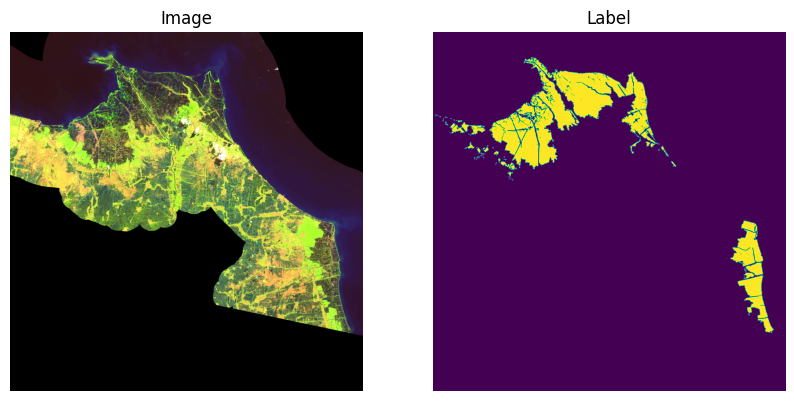

In [ ]:
band_composite=(2,1,0)
stretch = True

plot_image_and_label(image_array, label_array, band_composite, stretch)

Last, we will look at the mask image.

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 1, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}


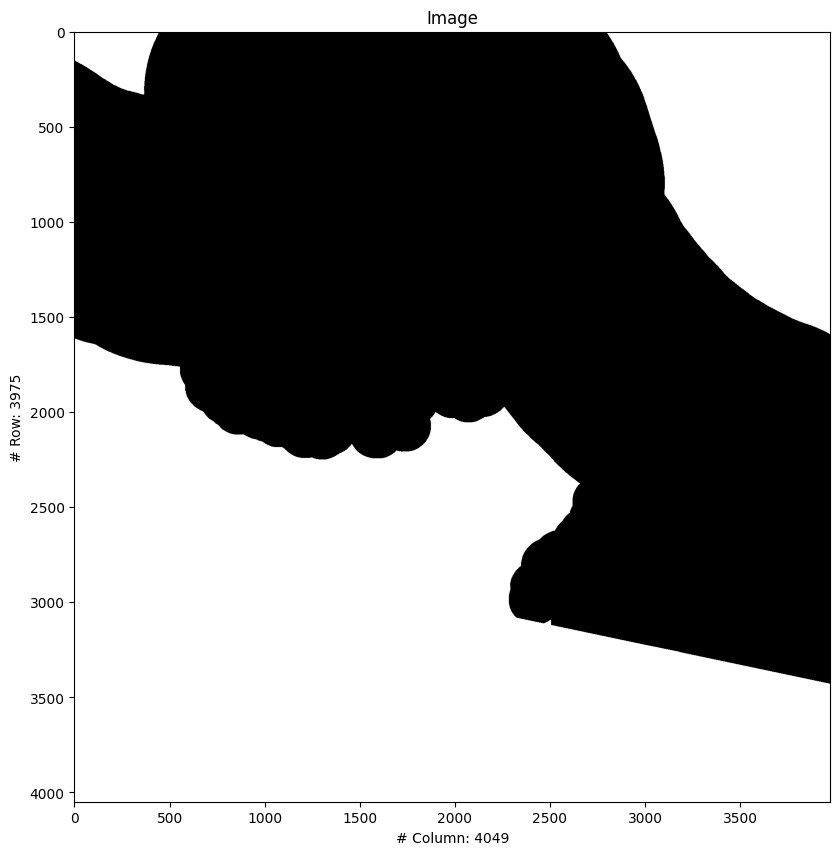

In [ ]:
msk_path = os.path.join(src_dir, catalog[catalog.usage=='train']['mask_dir'][0])

with rasterio.open(msk_path) as src:
    print(src.profile)
    mask_array = src.read(1)

plot_image(mask_array, "Greys")

So that's the imagery.  Now we will to move on to examining augmentations.

#### Test the image processing/augmentation functions

You will want to see--and demonstrate--how the augmentations work, and we will want to see them outside of the data loader that you will be making below.  So, let's run them first.  

##### Normalization

You will need to start by applying image normalization. Run your normalization code here. If you developed one that can clip the tails of the distribution, use that here, and it will be worth an extra 3 points.

You might want to write a function that simultaneously loads the image and applies the normalization at the same time. You might even want to make it so that the function can differentiate between images and labels. For the images, note that you will have to be careful might have to be careful to run the transpose after normalizing.  


###### **Optional coding assignment 1**

(3 points)

Modify the min-max input normalization (`min_max_normalize_image`) to clip the tail distributions based on a "clip_threshold" argument. For instance, trim of the 1st and 99th percentile values in each image.  (3 points)


To do this, modify the `min_max_normalize_image` function cell below, renaming it `min_max_normalize_image_wclip`. Run it instead of `min_max_normalize_image` when normalizing your image (we recommend applying a 1% clip to either tail), both here and in the custom loader.




In [ ]:
## Modify the normalization function here. Otherwise leave as is.
def min_max_normalize_image_wclip(image, clip_threshold):
    """
    Args:
        image (numpy array) -- Input image array.
        clip_threshold (float) -- Threshold for clipping the tail distributions.
        dtype (numpy datatype) -- Data type of the normalized image.

    Returns:
        numpy.ndarray: Normalized image array.

    """

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Calculate the percentile values for clipping
    clip_min_values = np.nanpercentile(image, clip_threshold * 100,
                                       axis=(1, 2))[:, np.newaxis, np.newaxis]
    clip_max_values = np.nanpercentile(image, (1 - clip_threshold) * 100,
                                       axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Clip the image data based on the threshold percentiles
    clipped_img = np.clip(image, clip_min_values, clip_max_values)

    # Normalize the clipped image data to the range [0, 1]
    normalized_img = (clipped_img - min_values) / (max_values - min_values)

    # Return the normalized image data
    return normalized_img

###### Load image and apply normalization

(1 point, with 3 extra if tail-clip normalization is completed)

In [ ]:
# Reading the image data as an array
with rasterio.open(img_path) as src:
  image_array = src.read()

# Applying modified normalization function
normalized_image = min_max_normalize_image_wclip(image_array, 0.02)

# Transposing dimensions
normalized_image = normalized_image.transpose(1, 2, 0)


###### Plot the normalized image
Show your result here by running the plotting code

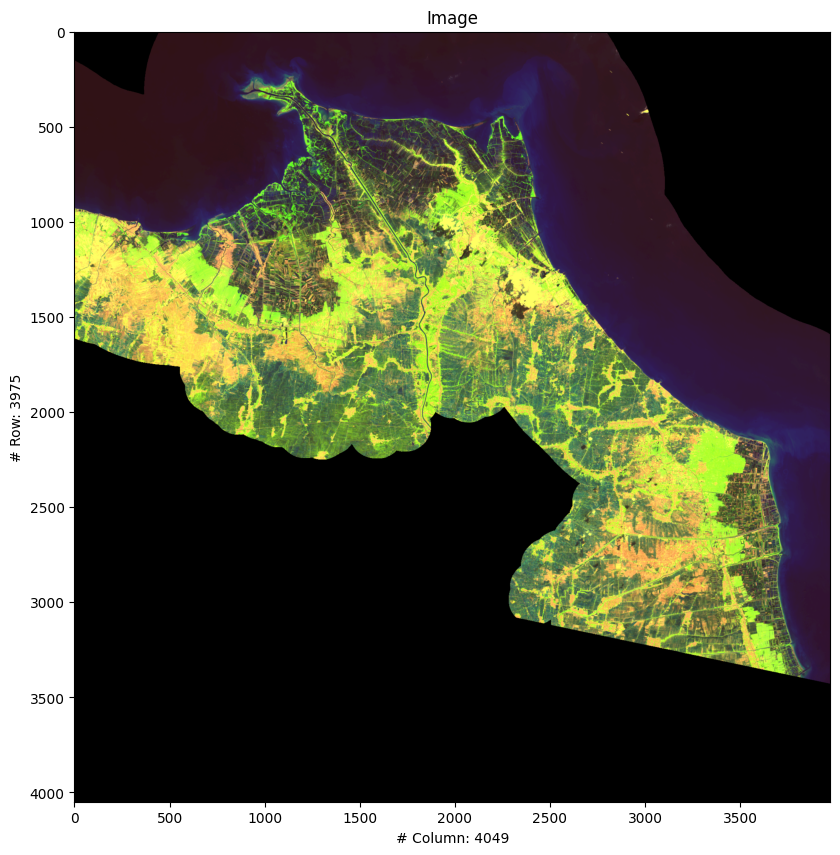

In [ ]:
plot_image(normalized_image, band_composite=band_composite, stretch=stretch)

##### Get a chip for testing

(2 points, with 5 extra if optional assignment is completed)

We want to now look at the different augmentations, outside of the data loader.  

This will require running the function for getting the center index, and then converting to chips. You can then extract a chip to test different augmentation functions.

You need a few ingredients here:

- Arguments:
    - patch_size = 256
    - overlap = 32
    - positive_class_threshold = 0.2
    - crop_ref = [mask, label]
- You will also need to divide patch_size in half correctly reference from cell center x, y to get the bounds of each chip.
- A list `coor` will be needed to catch the indices for x, y, which is the output from `patch_center_index`.
- A list to catch the image chips, and one to catch the label chips.
- To get an image chip you need to do something like this:

  ```python
  img_chips = []  # list to catch the chips
  half_win = patch_size // 2  # 1/2 patch size
  # subset image--note the extra dimension for the channel
  img_chips.append(img[x-half_win:x+half_win,   
                       y-half_win:y+half_win, :])
  ```

In [ ]:
 # List of center indices for x, y
image_chips = []  # list to catch the image chips
label_chips = [] # List to store label chips

patch_size = 256
half_win = patch_size // 2  # 1/2 patch size
overlap = 32
half_win = patch_size // 2  # 1/2 patch size

coor = patch_center_index(cropping_ref = [mask_array, label_array],
                          patch_size = patch_size,
                          overlap = overlap,
                          usage = "train",
                          positive_class_threshold=0.2, verbose=True)

# subset image--note the extra dimension for the channel

for center_x, center_y in coor:
    image_chips.append(image_array[center_x - half_win: center_x + half_win,
                         center_y - half_win: center_y + half_win, :])
    label_chips.append(label_array[center_x - half_win: center_x + half_win,
                             center_y - half_win: center_y + half_win])


Number of patches: 58
Patched from:
[[1088, 320], [1088, 704], [1280, 704], [896, 896], [1088, 896], [1280, 896], [1472, 896], [704, 1088], [896, 1088], [1088, 1088], [1280, 1088], [1472, 1088], [512, 1280], [704, 1280], [896, 1280], [1088, 1280], [1280, 1280], [1472, 1280], [512, 1472], [704, 1472], [896, 1472], [1088, 1472], [512, 1664], [704, 1664], [896, 1664], [512, 1856], [704, 1856], [896, 1856], [512, 2048], [704, 2048], [512, 2240], [704, 2240], [896, 2240], [1088, 2240], [704, 2432], [896, 2432], [1088, 2432], [2432, 3392], [2624, 3392], [2240, 3584], [2432, 3584], [2624, 3584], [2816, 3584], [3008, 3584], [2624, 3776], [2816, 3776], [3008, 3776], [3200, 3776], [320, 2624], [1856, 1664], [128, 2048], [704, 2624], [704, 128], [1856, 3776], [128, 2240], [1088, 2816], [2432, 3200], [512, 512]]


###### **Optional coding assignment 2**

(5 points)

Can you modify the chipping code to get the index of the upper left corner of each small chip, instead of getting the center point? If you decide to make the change make sure you also make appropriate changes when you are using those indices in the actual chipping process. (5 points)

If you are going to do this, modify the function for getting the center index (call it `get_upperleft_index`) in the cell below. Run it instead of `get_center_index` when making your chips, both here and in the custom loader. Note that the advice above for making the chips will differ a bit also.

In [ ]:
### Add your indexing function here.  Otherwise leave as is.
def get_upperleft_index(image_array, patch_size, overlap):
    """
    Calculate the upper left corner indices for each chip
    based on patch size and overlap.

    Args:
    image_array (numpy array): Input image array.
    patch_size (int): Size of the patch or chip.
    overlap (int): Overlap between patches.

    Returns:
    List of tuples: Upper left corner indices for each chip.
    """
    upperleft_indices = []
    step = patch_size - overlap

    for i in range(0, image_array.shape[0], step):
        for j in range(0, image_array.shape[1], step):
            upperleft_indices.append((i, j))

    return upperleft_indices



In [ ]:
np.shape(image_array)

(3, 4049, 3975)

###### Apply chipping

In [ ]:
# index = #call the chipping function with proper arguments
upperleft_index = get_upperleft_index(image_array, patch_size=256, overlap=32)
print(upperleft_index)

[(0, 0), (0, 224), (0, 448), (0, 672), (0, 896), (0, 1120), (0, 1344), (0, 1568), (0, 1792), (0, 2016), (0, 2240), (0, 2464), (0, 2688), (0, 2912), (0, 3136), (0, 3360), (0, 3584), (0, 3808), (0, 4032)]


###### Plot your selected chip

Select a single chip by index and then plot it--both the image and label chip.

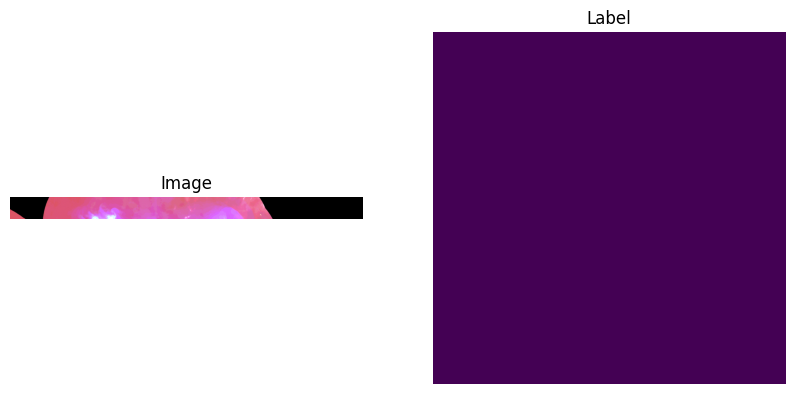

In [ ]:
def img_lbl_chip(image_array, label_array, indices):
  img_chips = []
  lbl_chips = []
  for x, y in indices:
      img_chip = image_array[x:x + patch_size, y:y + patch_size, :]
      img_chips.append(img_chip)
      lbl_chip = label_array[x:x + patch_size, y:y + patch_size]
      lbl_chips.append(lbl_chip)

  return img_chips.copy(), lbl_chips.copy()

# Creating chips using img_chip and lbl_chip functions
# image chips
image_chips, label_chips = img_lbl_chip(image_array=image_array,
                                        label_array = label_array,
                                        indices = upperleft_index)

# plot the selected image and label (e.g in this case I select first index)
plot_image_and_label(image_chips[0], label_chips[0],
                     band_composite = (2, 1, 0),
                     stretch=True)

In [ ]:
print(image_chips[0].shape)
print(label_chips[0].shape)


(3, 256)
(256, 256)


##### Augmentation 1

(1 point)

Run your first chosen augmentation here. If you are using a different function than rotation or flipping, place the function in the next cell, and run it in the cell after that.

###### Augmentation function (optional)

In [ ]:
### Add your first augmentation function here, if using a different function
# then those provided here. Otherwise, leave this as is

###### Apply augmentation

In [ ]:
### fill in augmentation code here
def rotate_image_and_label_scipy(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label using the
    scipy library.

    Args:
        image (numpy.ndarray): The input image patch as a numpy array.
        label (numpy.ndarray): The corresponding label as a numpy array.
        angle (list or tuple of floats): If the list has exactly two elements,
        they will be considered the lower and upper bounds for the rotation
        angle (in degrees) respectively. If the number of elements is
        greater than 2, then one value is chosen randomly as the rotation angle.

    Returns:
        tuple: A tuple containing the rotated image patch and label as
        numpy arrays.
    """
    if isinstance(angle, (tuple, list)):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter 'angle' needs at least two elements.")
    else:
        raise ValueError("Rotation bound param for augmentation tuple or list.")

    # Apply rotation augmentation to the image patch
    rotated_image = rotate(input=image, angle=rotation_degree, axes=(1, 0),
                           reshape=False, mode='reflect')

    # Apply rotation augmentation to the label
    rotated_label = rotate(input=label, angle=rotation_degree, axes=(1, 0),
                           reshape=False, mode='nearest')

    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), rotated_label.copy()




###### Plot your augmented chip

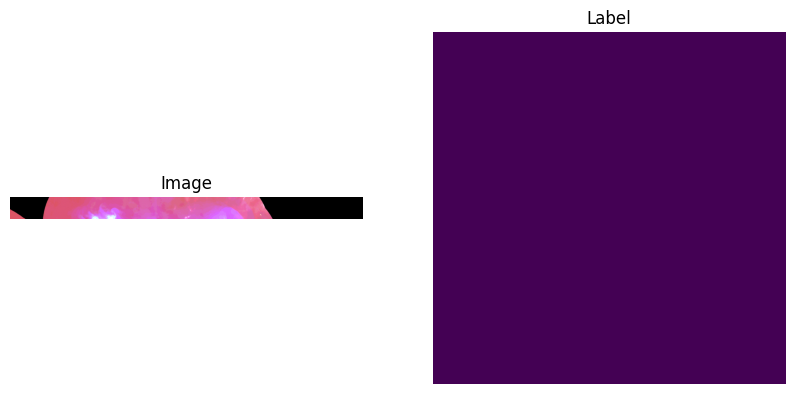

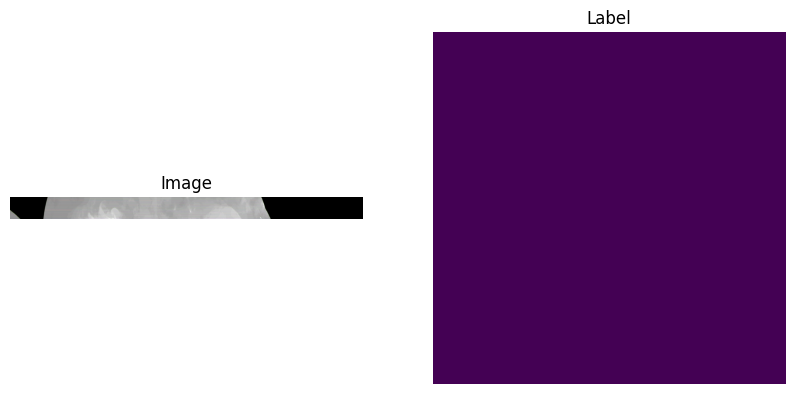

In [ ]:
img_chips_sel1 = image_chips[0]
lbl_chips_sel1 = label_chips[0]

rotation_angle = (0, 90)
band_composite = (2, 1, 0)

img_chips_aug1, lbl_chips_aug1 = rotate_image_and_label_scipy(
    img_chips_sel1, lbl_chips_sel1, rotation_angle)

# Plot selected chips
plot_image_and_label(img_chips_sel1, lbl_chips_aug1,
                     band_composite, stretch = True)

# plot first augmented chips
plot_image_and_label(img_chips_aug1, lbl_chips_aug1,
                     band_composite, stretch = True)

##### Augmentation 2

(1 point)

Run your second chosen augmentation here. If you are using a different function than rotation or flipping, place the function in the next cell, and run it in the cell after that.

###### Augmentation function (optional)

In [ ]:
### Add your second augmentation function here, if using a different function
# then those provided here. Otherwise, leave this as is

###### Apply second augmentation

In [ ]:
#@title Image Flipping using "numpy" library
def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either
            'hflip' or 'vflip'.

    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """
    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = np.flip(image, axis=1)

        # Apply horizontal flip augmentation to the label
        flipped_label = np.flip(label, axis=1)

    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = np.flip(image, axis=0)

        # Apply vertical flip augmentation to the label
        flipped_label = np.flip(label, axis=0)

    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")

    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()

###### Plot your augmented chip

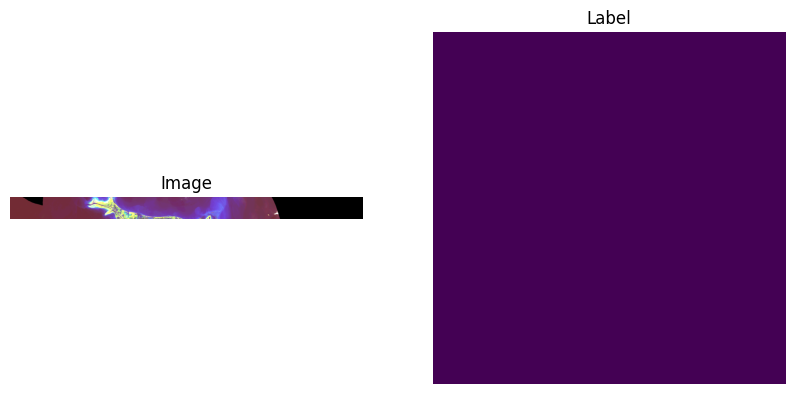

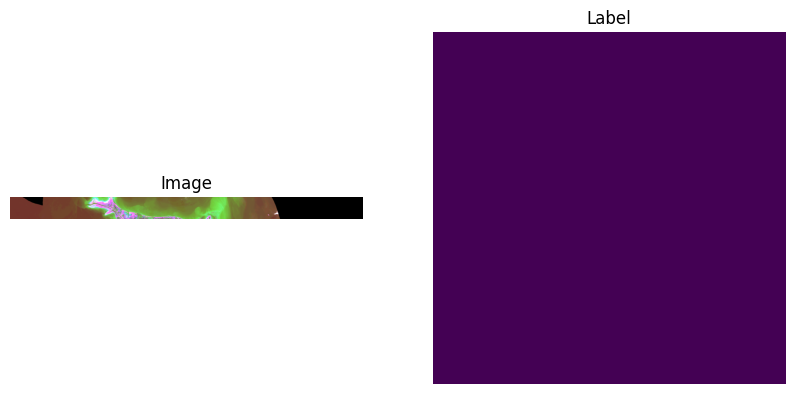

In [ ]:
img_chips_sel2 = image_chips[1]
lbl_chips_sel2 = label_chips[1]

band_composite = (2, 1, 0)

img_chips_aug2, lbl_chips_aug2 = flip_image_and_label(image = img_chips_sel2,
                                                        label = lbl_chips_sel2,
                                                        flip_type="vflip")


# plotting second augmentation applied image and label
plot_image_and_label(img_chips_sel2, lbl_chips_sel2, band_composite, stretch = True)

plot_image_and_label(img_chips_aug2, lbl_chips_aug2, band_composite, stretch = True)

#### Create and demonstrate your loader

(15 points)

##### Create your loader
(10 points)

Adapt the template below to create your custom data loader.

I get help from Chatgpt for solving this chunk.


In [ ]:
class ActiveLoadingDataset(Dataset):
    def __init__(self, src_dir, csv_name, usage, patch_size, overlap,
                 positive_class_threshold = 0.15, apply_normalization=True,
                 transform=None, **kargs):
        r"""
        src_dir (str or path) : Root of resource directory.
        csv_name (str) : Name of the csv file containing the input paths.
        usage (str) : Either 'train' or 'validation'.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : Amount of overlap (in pixels) between extracted chips.
        positive_class_threshold (float) : A real value as a threshold for the
            proportion of positive class to the total areal of the chip. Used to
            decide if the chip should be considered as a positive chip in the
            sampling process.
        transform (list) -- Each element is string name of the transformation to
             be used, e.g. ["rotate", "flip"]
        """
        self.src_dir = src_dir
        self.csv_name = csv_name
        self.overlap = overlap
        self.positive_class_threshold=positive_class_threshold
        self.transform = transform

        self.usage = usage
        assert self.usage in ["train", "validate"], "Usage is not recognized."

        self.patch_size = patch_size
        half_size = patch_size // 2

        catalog = pd.read_csv(Path(src_dir) / csv_name)
        self.catalog = catalog[catalog.usage==self.usage]

        self.img_chips = []
        self.lbl_chips = []
        self.coor = []

        # img_path = self.catalog["img_dir"]
        # lbl_path = self.catalog["label_dir"]
        # mask_path = self.catalog["mask_dir"]
        # from google.colab import drive
        # drive.mount("/content/gdrive")

        for _, row in self.catalog.iterrows():
            img_path = Path(src_dir) / row["img_dir"]
            lbl_path = Path(src_dir) / row["label_dir"]
            mask_path = Path(src_dir) / row["mask_dir"]

            # Load the image, label, and mask using rasterio
            with rasterio.open(img_path) as src:
                img = src.read().transpose(1, 2, 0)
            with rasterio.open(lbl_path) as src:
                lbl = src.read(1)
            with rasterio.open(mask_path) as src:
                mask = src.read(1)

            crop_ref = [mask, lbl]

            index = get_upperleft_index(img, self.patch_size, self.overlap)

            # Iterate over the indices to chip the image and label
            for x, y in index:
                self.coor.append([x, y])
                img_chip = img[x:x + self.patch_size, y:y + self.patch_size, :]
                lbl_chip = lbl[x:x + self.patch_size, y:y + self.patch_size]
                self.img_chips.append(img_chip)
                self.lbl_chips.append(lbl_chip)

        msg = '--------------{} patches cropped--------------'
        print(msg.format(len(self.img_chips)))

    def __getitem__(self, index):

        image_chip = self.img_chips[index]
        label_chip = self.lbl_chips[index]

        if self.usage == "train" and self.transform:
          if random.randint(0, 1) and "rotate" in self.transform:
                angle_range = (0, 90)
                image_chip, label_chip = rotate_image_and_label_scipy(
                    image_chip, label_chip, angle_range)

          # Convert numpy arrays to torch tensors.
        image_tensor = torch.from_numpy(image_chip.transpose((2, 0, 1))).float()
        label_tensor = torch.from_numpy(np.ascontiguousarray(label_chip)).long()

        return image_tensor, label_tensor

    def __len__(self):
      length = len(self.img_chips)

      return length


    def get_upperleft_index(image_shape, patch_size, overlap):
      indices = []
      step_size = patch_size - overlap
      for x in range(0, image_shape[0] - patch_size + 1, step_size):
          for y in range(0, image_shape[1] - patch_size + 1, step_size):
            indices.append((x, y))
      return indices


    def rotate_image_and_label_scipy(image, label, angle):
      if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
          rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
          rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter 'angle' needs at least two elements.")
      else:
          raise ValueError("Rotation bound param for augmentation tuple or list.")

      rotated_image = rotate(input=image, angle=rotation_degree, axes=(1, 0),
                           reshape=False, mode='reflect')
      rotated_label = rotate(input=label, angle=rotation_degree, axes=(1, 0),
                           reshape=False, mode='nearest')

      return rotated_image.copy(), rotated_label.copy()

    def flip_image_and_label(image, label, flip_type):
      if flip_type == 'hflip':
        flipped_image = np.flip(image, axis=1)
        flipped_label = np.flip(label, axis=1)
      elif flip_type == 'vflip':
        flipped_image = np.flip(image, axis=0)
        flipped_label = np.flip(label, axis=0)
      else:
        raise ValueError("Flip type must be 'hflip' or 'vflip'.")

      return flipped_image.copy(), flipped_label.copy()


##### Demonstrate your loader
(5 points)

Use/adapt the following arguments to run code.

In [ ]:
src_dir = "/content/gdrive/MyDrive/data/imagery/assignment3_data/"
csv_name = "pond_scenes_train_val.csv"
usage = "train"
patch_size = 256
overlap = 32
positive_class_threshold = 0.2
apply_normalization = True
transform = [] # fill list with your transforms

###### Training dataset

In [ ]:
train_dataset = ActiveLoadingDataset(
    src_dir, csv_name, usage, patch_size, overlap,
    positive_class_threshold, apply_normalization, transform
)
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)

--------------342 patches cropped--------------


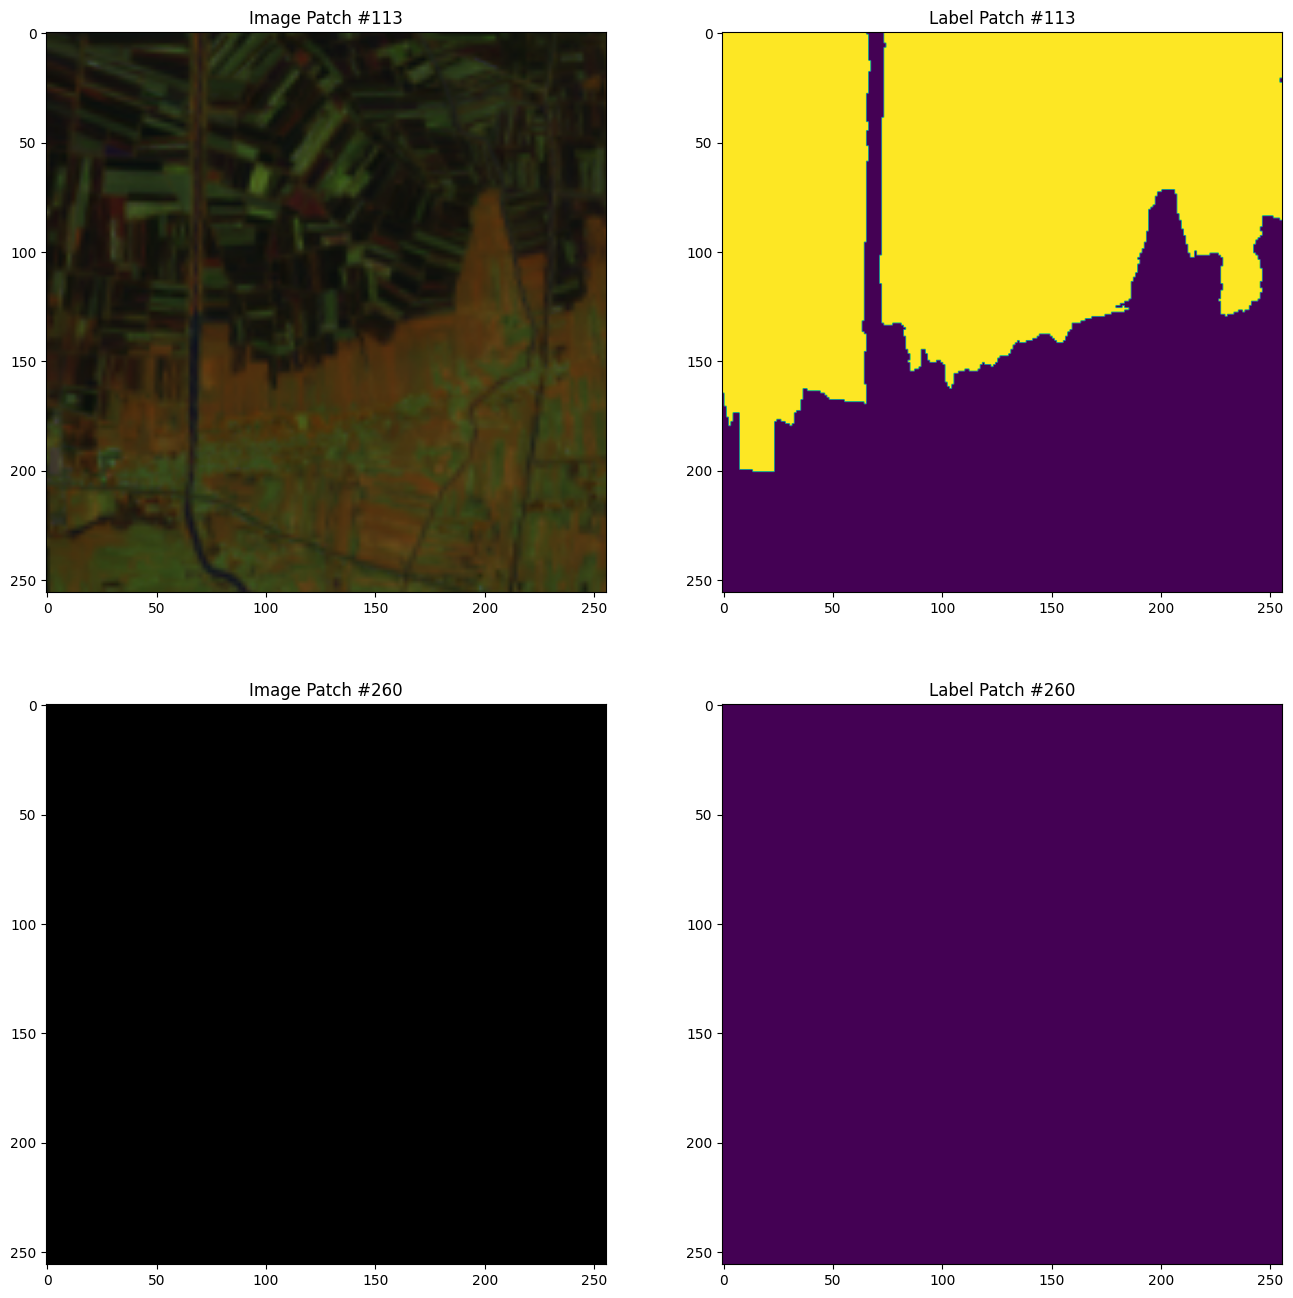

In [ ]:
show_random_patches(train_dataset, sample_num=2, rgb_bands=(0, 1, 2))

###### Validation dataset

In [ ]:
### Update the code to run the loader for the validation dataset
src_dir = "/content/gdrive/MyDrive/data/imagery/assignment3_data/"
csv_name = "pond_scenes_train_val.csv"
validation_dataset = ActiveLoadingDataset(
    src_dir=src_dir,
    csv_name=csv_name,
    usage = "validate",
    patch_size = 256,
    overlap=32,
    positive_class_threshold = 0.2,
    apply_normalization = True,
    transform=["vflip"]
)


--------------812 patches cropped--------------


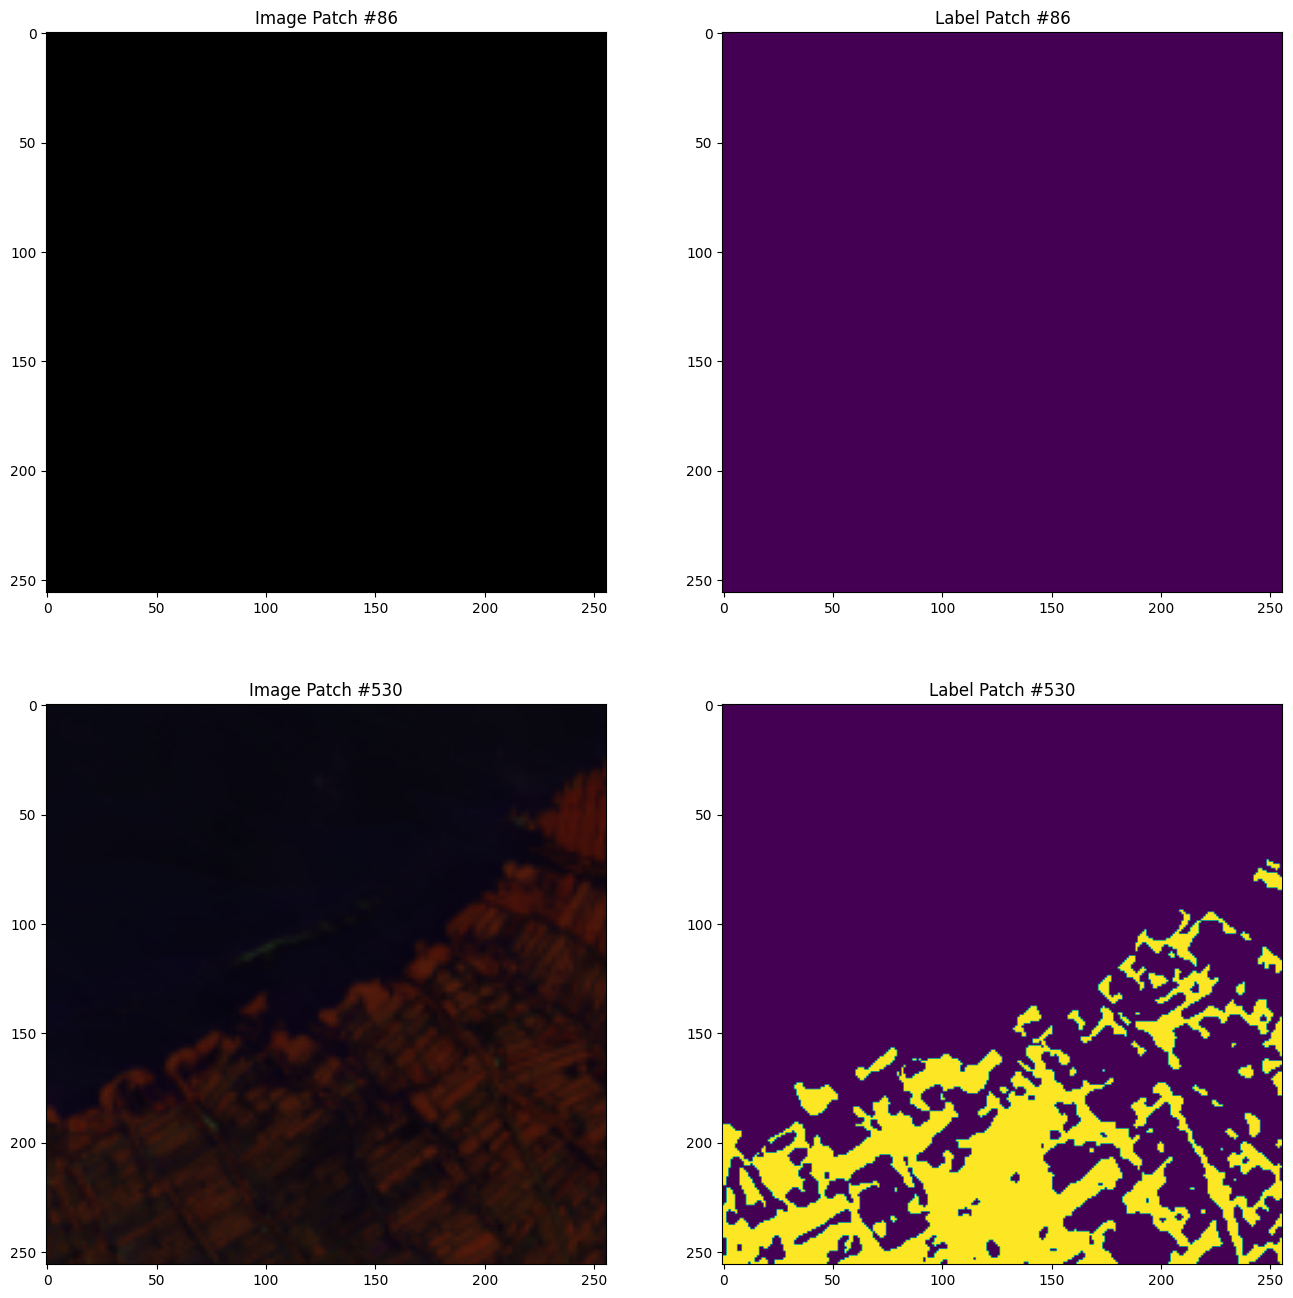

In [ ]:
show_random_patches(validation_dataset, sample_num=2, rgb_bands=(0, 1, 2))